# Predicting Momentum Events in The Stock Market

#### TASK: FIND AN INDICATOR FOR MOMENTUM

*At a high level, this notebook consists of building many different features that capture different aspects of momentum, then building a model based on these features to predict the chosen momentum-proxy and running the model on the data in a walk-forward fashion, before finally assessing the model performance.*

#### RESULT: The momentum-predicting model airs on the side of caution, over-predicting no-momentum regimes.  Yet, when the model determines there is momentum, it is accurate in predicting the direction of the movement

## Overview: 

As before, I am dealing with OHLCV data downloaded from yahoo.  I build a class that uses the Kalman filter to provide estimates of what can be intuitively understood as the stock's position, velocity, and momentum.  I then build a class that uses principal component analysis (PCA) to transform a set of highly-correlated relative strength indices (RSIs) (where the pair-wise correlation ranges from approxiamtrly 0.5 to 0.99 based on my tests) into a small set of scores.  Following this, I build the remaining features, which range in complexity from simple moving averages to Z-scored illiquidity measures.  The full list of features is below.

## Features


### Class-Based Features
- `PCA_RSI` - Generates principal component scores based on PCA of a set of RSIs with different lags
- `KalmanFilterMomentum` - Generates estimates of the stock's position, velocity, and acceleration

### Volatility Features
- `vol_n(returns, n)` - Rolling standard deviation volatility
- `ewm_vol_n(returns, n)` - Exponentially weighted moving average volatility  
- `parkinson_vol(ohlc, window)` - Parkinson estimator using high-low range
- `ewm_vol_20` - 20-period EWM volatility
- `vol_10` - 10-period rolling volatility
- `parkinson_vol_15` - 15-period Parkinson volatility estimator

---

### Price-Based Features

##### Moving Averages
- `sma(price, n)` - Simple moving average
- `ema(price, n)` - Exponential moving average
- `SMA(5)`, `SMA(20)` - Simple moving averages for 5 and 20 periods
- `EMA(5)`, `EMA(20)` - Exponential moving averages for 5 and 20 periods

##### Normalized Distance Measures
- `sma_dist(price, n)` - Variance-adjusted distance from SMA
- `ema_dist(price, n)` - Variance-adjusted distance from EMA
- `SMA_dist(5)`, `SMA_dist(20)` - Variance-adjusted SMA distances
- `EMA_z(5)`, `EMA_z(20)` - Z-scored EMA deviations

##### Technical Oscillators
- `rsi(price, n)` - Relative Strength Index momentum oscillator
- `psychological_line(close, n)` - Percentage of up closes over n periods
- `Psych Line` - 20-period psychological line indicator

---

### Signal Comparison Features

##### Cross-Signal Analysis
- `spread(signal1, signal2)` - Simple difference between two signals
- `signal_above_below(signal1, signal2)` - Binary indicator of signal1 > signal2
- `crossover(signal1, signal2)` - Detects bullish (+1) and bearish (-1) crossovers
- `5over20` - Crossover signals between 5-period and 20-period SMAs

##### Multi-Signal Aggregation
- `ribbon_count(df)` - Counts aligned signals in a ribbon of moving averages

---

### OHLC-Specific Features

##### Price Relationships
- `typical_price(ohlc)` - (High + Low + Close) / 3
- `HLC_ratio(ohlc)` - (High - Low) / Close, measures intraday volatility
- `OC_ratio(ohlc)` - (Open - Close) / Close, measures session performance
- `Typical` - Typical price indicator

##### Stochastic Indicators
- `stochasticK(ohlc, n)` - %K stochastic oscillator
- `stochasticD(stochastick, n)` - %D smoothed stochastic
- `Stochastic K` - 14-period %K stochastic
- `Stochastic D` - 3-period smoothed %D stochastic

---

### Advanced Momentum & Microstructure Features

##### Volatility-Normalized Returns
- `zret_1` - 1-step return normalized by volatility

##### Trend & Momentum
- `ema_diff_z` - Volatility-normalized MACD-like EMA difference
- `slope_t_10`, `slope_t_20`, `slope_t_30` - T-statistic normalized linear regression slopes

##### Breakout & Range Analysis
- `donch_pos_20`, `donch_pos_50` - Position within Donchian channels
- `dist_top_20`, `dist_top_50` - Distance to channel top
- `dist_bot_20`, `dist_bot_50` - Distance to channel bottom

##### Volatility Regime Features
- `range_rel` - Relative range measure
- `sigma_pct` - Volatility percentile rank
- `range_bw_z` - Z-scored range bandwidth

##### Microstructure & Persistence
- `net_up_k` - Net up moves over k periods
- `clv` - Close Location Value, intraday momentum
- `gap_z` - Volatility-normalized overnight gaps

##### Volume-Based Features
- `vol_z` - Z-scored volume
- `vol_over_sigma` - Volume relative to volatility
- `illiq_z` - Z-scored illiquidity measure (Amihud-style)

---

### Time Series Modeling Features

##### Autoregressive Features
- `ar1_h_pred_z` - Volatility-normalized AR(1) h-step ahead prediction
- `ar1_resid_volnorm_z` - Volume-aware standardized AR(1) residuals
- `arx_pred_1_z` - ARX model with volume interaction for 1-step prediction

##### Market Regime Features
- `hurst` - Rolling Hurst exponent for trend persistence
- `hurst ewm` - Exponentially smoothed Hurst exponent



# Target

In addition to transforming the OHLCV data, I also generate a transformed target.  To me, it is not entirely obvious what concretely we are trying to predict when developing a momentum model.  Is it cumulative returns over a period?  If so, what period?  And if this is the case, then this assumes that the strength of the trend matters.  But should it?  Maybe then the target should be some simple count, to avoid issues of conflating strength of a trend with momentum itself.  But then, what to count?  The number of close prices above the previous day's, or something else?  Deciding what even should be my target has been a point of philosophical contention for me the entire time I have been working on this project. 

Ultimately, I decided on a volatility-adjusted ternary target, $\tau_t$, where:

$$\tau_t = k \times \sigma_t \times \sqrt{h}$$

$$y_t = \begin{cases} 
+1 & \text{if } \text{future return} > +\tau_t \text{ (significant up move)} \\
-1 & \text{if } \text{future return} < -\tau_t \text{ (significant down move)} \\
0 & \text{otherwise (neutral/small move)}
\end{cases}$$
Where:
- $k$ = sensitivity parameter (default 0.3, or auto-tuned)
- $\sigma_t$ = current 1-step EWM volatility 
- $h$ = forecast horizon (e.g., 20 days)

The idea here is that a 2% move might be huge during calm periods, but normal during volatile times. Using this as a target, the model learns to predict moves that are surprising relative to current volatility, not just raw magnitude.

With both my features and target in place, I set out to see how good of a classification model I could build.  I decided to proceed with a `RandomForestClassifier` for this task.  I trained my model using a two-stage pipeline consisting of feature selection followed by optimized classification.  In particular, I used Recursive Feature Elimination (`RFE`) paired with a `RandomizedSearchCV`, and assessed the results using multi-class weifhted ROC-AUC.  I then use the best model for the purposes of that walk-forward step before retraining and repeating the process again.

Once my model has run its course, I create various diagnostic plots to assess the model performance.  What I found is that the model over-predicts the "no-momentum" regime.  While this means that there are missed training opportunities, what I believe is more important is that the model is usually right!  And indeed, from the testing that I have done, the model does a very good job at correctly predicting the direction of momentum when it does predict either upwards or downwards momentum.

Hopefully the above enhances the readability of the notebook.  Now on to feature engineering.

### Feature Engineering

Load libraries for data access, feature engineering, plotting, and state-space modeling.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pykalman import KalmanFilter
from scipy.linalg import solve_discrete_are
from typing import List
import numpy.linalg as la
import nolds


Define a `KalmanFilterMomentum` class to estimate and track latent position, velocity, and acceleration of an asset price using a constant-acceleration state-space model. The training estimates the noise covarainces using expectation maximization, the initial state using simple difference equations, and the error covariance using the algebriac discrete Ricatti equation (which I found to be superior to the EM estimate in my stat arb strategy).  Other methods enable one-step predictions and updates, and well as a convenient method for generating a set of out-of-sample predictions.

In [2]:
class KalmanFilterMomentum:
    # Initialize the class with slots for the state variables and other parameters
    def __init__(self, h):
        self.h = h
        self.A = np.array([[1,h,.5*h**2], [0,1,h], [0,0,1]])
        self.H = np.array([[1,0,0]])
        self.kf = None
        self.cur_state = None
        self.cur_covar = None
    
    # Builds the Kalman filter using training data
    def train(self, data, label='Close'):
        # Handle DataFrame
        if hasattr(data, 'columns'):
            prices = data[label]
    
        # Handle numpy array
        else:
            prices = data

            
        prices_array = np.array(prices).reshape(-1,1)
        initial_state = self.estimate_initial_state(prices_array)
        
        # Initial Q and R for EM
        self.Q = np.eye(3)*0.001
        self.R = np.array([[0.01]])
        
        self.kf = KalmanFilter(transition_matrices=self.A,
                          observation_matrices=self.H,
                          transition_covariance=self.Q,
                          observation_covariance=self.R,
                          initial_state_mean=initial_state)

        # Run EM to learn both Q and R
        self.kf = self.kf.em(prices_array, n_iter=50, 
                            em_vars=['transition_covariance', 'observation_covariance'])

        # Compute steady-state covariance using learned parameters
        P_ss = self.compute_steady_state_covariance()

        # Retrain with proper initial covariance and learned parameters
        self.kf = KalmanFilter(transition_matrices=self.A,
                              observation_matrices=self.H,
                              transition_covariance=self.kf.transition_covariance, 
                              observation_covariance=self.kf.observation_covariance,  
                              initial_state_covariance=P_ss,
                              initial_state_mean=initial_state)

        # Final smoothing pass
        state_means, state_covars = self.kf.smooth(prices_array)
        self.cur_state = state_means[-1]
        self.cur_covar = state_covars[-1]
                
    # predict the next state
    def predict(self):
        pred_state = self.A @ self.cur_state
        pred_covar = self.A @ self.cur_covar @ self.A.T + self.kf.transition_covariance
        return pred_state, pred_covar

    # predict next state and update state variables based on the next observation
    def update(self, next_price):
        pred_state = self.A @ self.cur_state
        pred_covar = self.A @ self.cur_covar @ self.A.T + self.kf.transition_covariance
        obs = np.array([[next_price]])
        S = self.H @ pred_covar @ self.H.T + self.kf.observation_covariance
        K = pred_covar @ self.H.T @ np.linalg.inv(S)
        innov = obs - self.H @ pred_state
        self.cur_state = pred_state + (K @ innov).flatten()
        self.cur_covar = (np.eye(3)-K @ self.H) @ pred_covar
        return self.cur_state, self.cur_covar[0,0]
        
    # Compute steady-state error covariance using discrete Riccati equation
    def compute_steady_state_covariance(self):
        F = self.A
        H = self.H  
        Q = self.kf.transition_covariance
        R = self.kf.observation_covariance

        # Fix asymmetry
        Q = (Q + Q.T) / 2
        R = (R + R.T) / 2

        P_ss = solve_discrete_are(F.T, H.T, Q, R)
        return P_ss
    
    # Estimate initial velocity and acceleration from historical data

    def estimate_initial_state(self, prices_array):
        p = np.array(prices_array).flatten()
        v = (p[1] - p[0]) / self.h 
        a = (p[2] - 2*p[1] + p[0]) / (self.h**2)
        return np.array([p[0], v, a])


    def generate_kalman_predictions(self, data, train_split_date, label='Close', h=1.0):
        """
        Generate Kalman filter predictions from a price Series without look-ahead bias.

        Parameters:
        - prices: pandas Series with datetime index and price values
        - train_split_date: Date to split training/testing
        - h: Time step for Kalman filter (default 1.0 for daily data)

        Returns:
        - DataFrame with datetime index and columns: 
          KF_Position, KF_Velocity, KF_Acceleration (predictions)
          KF_Position_Updated, KF_Velocity_Updated, KF_Acceleration_Updated (after update)
        """
        # Create result dataframe with same index
        prices = data[label]
        result = pd.DataFrame(index=prices.index)

        # Initialize prediction columns
        result['KF_Position'] = np.nan
        result['KF_Velocity'] = np.nan
        result['KF_Acceleration'] = np.nan

        # Initialize updated state columns 
        #result['KF_Position_Updated'] = np.nan
        #result['KF_Velocity_Updated'] = np.nan
        #result['KF_Acceleration_Updated'] = np.nan

        # Get training data
        train_data = prices.loc[prices.index < train_split_date].values

        # Initialize and train Kalman filter
        kf_model = KalmanFilterMomentum(h=h)
        kf_model.train(train_data)


        # Fill in training period with smoothed states 
        train_prices = train_data.reshape(-1, 1)
        state_means, _ = kf_model.kf.smooth(train_prices)

        train_indices = prices[prices.index < train_split_date].index
        for i, idx in enumerate(train_indices):
            if i < len(state_means):
                result.loc[idx, 'KF_Position'] = state_means[i, 0]
                result.loc[idx, 'KF_Velocity'] = state_means[i, 1]
                result.loc[idx, 'KF_Acceleration'] = state_means[i, 2]


        # For out-of-sample period: predict one step ahead, then update
        test_prices = prices[prices.index >= train_split_date]
        test_indices = list(test_prices.index)

        for i, idx in enumerate(test_indices):
            # Predict for current step
            pred_state, _ = kf_model.predict()

            # Store prediction on previous day (if not first iteration)
            if i > 0:
                prev_idx = test_indices[i - 1]
                result.loc[prev_idx, 'KF_Position'] = pred_state[0]
                result.loc[prev_idx, 'KF_Velocity'] = pred_state[1] 
                result.loc[prev_idx, 'KF_Acceleration'] = pred_state[2]
            else:
                # Store first test prediction on last training day
                if len(train_indices) > 0:
                    last_train_idx = train_indices[-1]
                    result.loc[last_train_idx, 'KF_Position'] = pred_state[0]
                    result.loc[last_train_idx, 'KF_Velocity'] = pred_state[1]
                    result.loc[last_train_idx, 'KF_Acceleration'] = pred_state[2]

            # Update with actual price
            actual_price = prices.loc[idx]
            updated_state, _ = kf_model.update(actual_price)

        # Handle the final prediction for the last day
        if len(test_indices) > 0:
            final_pred, _ = kf_model.predict()
            last_idx = test_indices[-1]
            result.loc[last_idx, 'KF_Position'] = final_pred[0]
            result.loc[last_idx, 'KF_Velocity'] = final_pred[1]
            result.loc[last_idx, 'KF_Acceleration'] = final_pred[2]

            # Store UPDATED state
            #result.loc[idx, 'KF_Position_Updated']     = updated_state[0]
            #result.loc[idx, 'KF_Velocity_Updated']     = updated_state[1]
            #result.loc[idx, 'KF_Acceleration_Updated'] = updated_state[2]

        return result

RSI is a useful momentum indicator. Deciding which window to use is not obvious. Rather than trying to determine the optimal window, I peform PCA on a group of RSIs of different lags

In [3]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import pandas_ta as ta
from typing import List, Optional

class PCA_RSI:
    """
    PCA on a set of RSI lookbacks.
    - fit(close_train): learn means/scale + PCA loadings on the TRAIN window only
    - transform(close_any): compute PC scores for the given close series
    Returns PC scores as a DataFrame with the SAME index as the input series.
    """
    def __init__(self, rsi_lbs: List[int], n_components: int = 2, standardize: bool = True):
        self.rsi_lbs = sorted(list(rsi_lbs))
        self.n_components = int(n_components)
        self.standardize = bool(standardize)

        # learned on fit()
        self.cols_: Optional[List[str]] = None
        self.means_: Optional[pd.Series] = None
        self.stds_: Optional[pd.Series] = None
        self.loadings_: Optional[np.ndarray] = None  # shape (p, k)

    def _rsis(self, close: pd.Series) -> pd.DataFrame:
        return pd.DataFrame({lb: ta.rsi(close, lb) for lb in self.rsi_lbs}, index=close.index)

    def train(self, data, label='Close'):
        close = data[label]
        rsis = self._rsis(close)
        X = rsis.dropna()                       # train only on rows with full RSI warmup
        self.cols_ = list(X.columns)

        # center (+ optional standardize) on train distribution
        self.means_ = X.mean()
        if self.standardize:
            self.stds_ = X.std(ddof=1).replace(0.0, 1.0)
            Z = (X - self.means_) / self.stds_
        else:
            self.stds_ = None
            Z = X - self.means_

        # PCA on covariance of Z
        Xz = Z.values
        U, S, Vt = la.svd(Xz, full_matrices=False)
        self.loadings_ = Vt.T[:, :self.n_components]
        #cov = np.cov(Z.values, rowvar=False)
        #evals, evecs = la.eigh(cov)
        #order = np.argsort(evals)[::-1]
        #self.loadings_ = evecs[:, order][:, :self.n_components]
        return self

    def transform(self, data, label='Close') -> pd.DataFrame:
        if self.loadings_ is None:
            raise RuntimeError("Call fit() first on a training window.")
        close = data[label]
        rsis = self._rsis(close)
        Z = rsis[self.cols_].copy()
        Z = Z - self.means_
        if self.standardize:
            Z = Z / self.stds_

        # matrix multiply; rows with any NaNs remain NaN in the scores
        scores = Z.values @ self.loadings_
        cols = [f"rsi_pc{j+1}" for j in range(self.loadings_.shape[1])]
        return pd.DataFrame(scores, index=rsis.index, columns=cols)


Here is a quick function and its helper to compute the Hurst exponent on a rolling window of price data

In [4]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# estimating the Hurst exponent (using detrended fluctuation analysis)
def hurst(timeseries, window=30):
    if len(timeseries) < window:
        return np.nan
    return nolds.dfa(np.diff(timeseries))

# helper method to calculate the Hurst exponent on a rolling window
def calculate_rolling_hurst_pandas(df, price_column='Close', window=30):
    df_result = df.copy()
    df_result['hurst'] = df[price_column].rolling(window=window, min_periods=window).apply(lambda x: hurst(x.values), raw=False)
    return df_result

This next block is hefty.  This is where the bulk of features are constructed

In [5]:
################# HELPERS  ##################

#OLS slope of x on time index over a rolling window (slope per bar).
def rolling_linreg_slope(x: pd.Series, window: int) -> pd.Series:
    """
    """
    n = window
    t = np.arange(n)
    t_mean = t.mean()
    t_demean = t - t_mean
    denom = (t_demean**2).sum()

    def _slope(arr):
        x_demean = arr - arr.mean()
        return (t_demean @ x_demean) / denom

    return x.rolling(n, min_periods=n).apply(_slope, raw=True)

#Rolling percentile rank of the last element in each window
def percentile_rank(s: pd.Series, window: int) -> pd.Series:

    def _pr(x):
        r = pd.Series(x).rank(pct=True)
        return r.iloc[-1]
    return s.rolling(window, min_periods=window).apply(_pr, raw=False)


################# RETURNS BASED ##############
def log_returns(price):
    return np.log(price).diff()

################# VOLATILITY ##############
def vol_n(returns,n):
    return returns.rolling(n).std()

def ewm_vol_n(returns, n):
    return returns.ewm(span=n, adjust=False).std(bias=False)

def parkinson_vol(ohlc, window, annualize=False):
    eps, trading_days = 1e-12, 252
    H = ohlc['High'].astype(float).clip(lower=eps)
    L = ohlc['Low'].astype(float).clip(lower=eps)

    log_hl = np.log(H / L)
    rs = (log_hl ** 2).rolling(window=window, min_periods=window).mean()
    pk = np.sqrt(rs / (4.0 * np.log(2.0)))

    if annualize:
        pk = pk * np.sqrt(trading_days)

    return pk

################# PRICE BASED #############
def sma(price: pd.Series, n: int):
        return price.rolling(n).mean()

def sma_dist(price: pd.Series, n: int, var_adj=False):
    adj = price.rolling(n).std() if var_adj else 1
    return (price / price.rolling(n).mean() -1) / adj

def sma_z(price: pd.Series, n:int):
    pct_dev = price / price.rolling(n).mean() - 1 
    mu = pct_dev.rolling(n).mean()
    sigma = pct_dev.rolling(n).std()
    z = (pct_dev - mu) / (sigma + 1e-12)
    return z

def ema(price, n):
    return price.ewm(span=n, adjust=False).mean()

def ema_dist(price: pd.Series, n: int, var_adj=False):
    ema_val = price.ewm(span=n, adjust=False).mean()
    adj = price.ewm(span=n, adjust=False).std() if var_adj else 1
    return (price / ema_val - 1) / (adj +1e-12)

def ema_z(price: pd.Series, n: int):
    ema_val = price.ewm(span=n, adjust=False).mean()
    pct_dev = price / ema_val - 1
    mu = pct_dev.ewm(span=n, adjust=False).mean()
    sigma = pct_dev.ewm(span=n, adjust=False).std()
    return (pct_dev - mu) / (sigma + 1e-12)

def rsi(price: pd.Series, n: int = 14):
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/n, min_periods=n, adjust=False).mean()

    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))

def psychological_line(close, n):
    up_closes = (close > close.shift(1)).astype(int)
    return up_closes.rolling(window=n).mean()*100

################ SIGNAL COMPARISON #############

def spread(signal1, signal2):
    return signal1-signal2

def signal_above_below(signal1, signal2):
    return (signal1 > signal2).astype(int)

def crossover(signal1, signal2):
    prev_state = signal1.shift(1) - signal2.shift(1)
    cur_state = signal1 - signal2
    up_cross = (prev_state <= 0) & (cur_state > 0)
    down_cross = (prev_state >= 0) & (cur_state < 0)
    return pd.Series(0, index=signal1.index).where(~up_cross, 1).where(~down_cross, -1)

################# OTHER #############

def ribbon_count(df: pd.DataFrame): # df columns must be ordered: fastest → slowest
    cols = df.columns
    parts = [(df[cols[i]] > df[cols[i+1]]).astype(int) for i in range(len(cols)-1)]
    return pd.concat(parts, axis=1).sum(axis=1) if parts else pd.Series(0, index=df.index)

def lagify(feat, n):
    return feat.shift(n)

############## OHLC ##############

def typical_price(ohlc):
    return (ohlc['High']+ohlc['Low']+ohlc['Close'])/3

def HLC_ratio(ohlc):
    return (ohlc['High']-ohlc['Low'])/ohlc['Close']

def OC_ratio(ohlc):
    return(ohlc['Open']-ohlc['Close']) / ohlc['Close']

def stochasticK(ohlc,n):
    #(close_t - lowestlow(n)) / (highesthigh(n) - lowestlow(n)) * 100
    lowest_low, highest_high = ohlc['Low'].rolling(n).min(), ohlc['High'].rolling(n).max()
    return (ohlc['Close'] - lowest_low) / (highest_high - lowest_low + 1e-12) * 100

def stochasticD(stochastick, n):
    return sma(stochastick, n)

def feature_generation(ohlcv, price_point='Close',
                       h=10, vol_span=20, ema_fast=10, ema_slow=30, slope_ws = (10,20,30),
                       donchian_ws = (20,50), rng_win = 14, vol_pct_win = 50, ar_win=50, 
                       reg_span =50, gamma_vol = 0.5):
    output = ohlcv.copy()
    price = output[price_point]
    output['Returns'] = log_returns(price)
    r1 = output['Returns']

    sigma1 = ewm_vol_n(r1, vol_span)
    ##### RETURNS BASED #####
    output['Returns'] = log_returns(price)
    output['ewm_vol_{}'.format(vol_span)] = sigma1
    output['vol_10'] = vol_n(r1, 10)
    output['parkinson_vol_15'] = parkinson_vol(output, 15, annualize=False)
    #for horizon in [5,23]:
    #    output[f"Cum Returns_{horizon}"] = cum_returns(output['Returns'], horizon)
    
    ###### PRICE BASED ######
    moving_average_lags = [5,20]
    for horizon in moving_average_lags: #[5,20,95,200] 
        output[f"SMA({horizon})"] = sma(price, horizon)
        #output[f"SMA-z({horizon})"] = sma_z(price, horizon)
        output[f"EMA({horizon})"] = ema(price, horizon)
        #output[f"SMA-z({horizon})"] = sma_z(price,horizon)
        output[f"EMA_z({horizon})"] = ema_z(price, horizon)
        output[f"SMA_dist({horizon})"] = sma_dist(price, horizon, var_adj=True)
        

        
    #output['RSI'] = rsi(price, 14)
    output['Psych Line'] = psychological_line(price, 20)
    
    ###### SIGNAL COMPARISON ######
    output['5over20'] = crossover(output['SMA(5)'], output['SMA(20)'])
    #output['20over101'] = crossover(output['SMA(20)'], output['SMA(101)'])
    
    #output['Ribbon']= ribbon_count(output[['SMA(5)', 'SMA(20)', 'SMA(95)', 'SMA(200)']])
    
    ###### OHLC #####
    output['Typical'] = typical_price(ohlcv)
    output['HLC_Ratio'] = HLC_ratio(ohlcv)
    output['OC_Ratio'] = OC_ratio(ohlcv)
    output['Stochastic K'] = stochasticK(ohlcv,14)
    output['Stochastic D'] = stochasticD(output['Stochastic K'],3)
    
    ###### hursty #####
    temp = calculate_rolling_hurst_pandas(ohlcv, price_column='Close', window=30)
    output = output.join(temp['hurst'])
    output['hurst ewm'] = output['hurst'].ewm(span=3,adjust=False, min_periods=3).mean()
    

    ##### Momentum/Breakout/Squeeze, added later ###

    logp = np.log(price)

    # vol-normalized 1-step return
    output["zret_1"] = r1 / (sigma1 + 1e-12)

    # MACD-like diff in log-space, vol-normalized by sigma1
    ema_f = price.ewm(span=ema_fast, adjust=False, min_periods=ema_fast).mean()
    ema_s = price.ewm(span=ema_slow, adjust=False, min_periods=ema_slow).mean()
    ema_diff = np.log(ema_f) - np.log(ema_s)   # smoother in logs
    output["ema_diff_z"] = ema_diff.diff() / (sigma1 + 1e-12)

    # linear-regression t-slope(s)
    for w in slope_ws:
        slope = rolling_linreg_slope(logp, w)
        trend = logp.rolling(w, min_periods=w).mean()  # cheap detrend
        resid_std = (logp - trend).rolling(w, min_periods=w).std()
        output[f"slope_t_{w}"] = slope / (resid_std + 1e-12)

    # Donchian geometry
    for w in donchian_ws:
        hh = price.rolling(w, min_periods=w).max()
        ll = price.rolling(w, min_periods=w).min()
        width = (hh - ll).replace(0, np.nan)
        output[f"donch_pos_{w}"] = (price - ll) / width
        output[f"dist_top_{w}"]  = (hh - price) / width
        output[f"dist_bot_{w}"]  = (price - ll) / width

    # Volatility regime / squeeze
    rng = (ohlcv["High"] - ohlcv["Low"]).abs()
    output["range_rel"] = (rng / price).rolling(rng_win, min_periods=rng_win).mean()
    output["sigma_pct"] = percentile_rank(sigma1, vol_pct_win)

    rng_ewm = rng.ewm(span=vol_span, adjust=False, min_periods=5).mean()
    rng_std = rng.ewm(span=vol_span, adjust=False).std()
    output["range_bw_z"] = (rng - rng_ewm) / (rng_std + 1e-12)

    # Persistence / microstructure
    k = max(3, h // 2)
    up = (price > price.shift(1)).astype(int)
    down = (price < price.shift(1)).astype(int)
    output[f"net_up_{k}"] = (up - down).rolling(k, min_periods=k).sum()

    clv = ((ohlcv["Close"] - ohlcv["Low"]) - (ohlcv["High"] - ohlcv["Close"])) / (ohlcv["High"] - ohlcv["Low"])
    output["clv"] = clv.replace([np.inf, -np.inf], np.nan)

    if "Open" in ohlcv.columns:
        output["gap_z"] = (np.log(ohlcv["Open"]) - np.log(ohlcv["Close"].shift(1))) / (sigma1 + 1e-12)

    # Volume features (+ illiquidity)
    if "Volume" in ohlcv.columns:
        v = ohlcv["Volume"].astype(float)
        v_ewm = v.ewm(span=vol_span, adjust=False, min_periods=5).mean()
        v_std = v.ewm(span=vol_span, adjust=False).std()
        output["vol_z"] = (v - v_ewm) / (v_std + 1e-12)
        output["vol_over_sigma"] = (v_ewm / v_ewm.rolling(50, min_periods=20).mean()) * (1.0 / (sigma1 + 1e-12))

        dollar_vol = (v * price).replace(0, np.nan)
        illiq = (r1.abs() / dollar_vol).replace([np.inf, -np.inf], np.nan)
        illiq_ewm = illiq.ewm(span=vol_span, adjust=False, min_periods=5).mean()
        illiq_std = illiq.ewm(span=vol_span, adjust=False).std()
        output["illiq_z"] = (illiq - illiq_ewm) / (illiq_std + 1e-12)
    else:
        output["vol_z"] = np.nan
        output["vol_over_sigma"] = np.nan
        output["illiq_z"] = np.nan

    ######## AR-based features ########
    # Rolling AR(1) coefficient a_t
    cov_r = r1.rolling(ar_win, min_periods=ar_win).cov(r1.shift(1))
    var_lag = r1.shift(1).rolling(ar_win, min_periods=ar_win).var()
    a = (cov_r / (var_lag + 1e-12)).clip(-0.99, 0.99)
    resid = r1 - a * r1.shift(1)

    # Volume surprise
    v_z = output["vol_z"] if "vol_z" in output.columns else pd.Series(index=ohlcv.index, dtype=float)
    v_z_pos = v_z.clip(lower=0)

    base_scale = resid.abs().ewm(span=vol_span, adjust=False, min_periods=5).mean()
    vol_scale = base_scale * (1.0 + gamma_vol * v_z_pos)

    # AR(1) → h-step projection, vol-normalized
    with np.errstate(divide='ignore', invalid='ignore'):
        geom = (1 - np.power(a, h)) / (1 - a.replace(1.0, np.nan))
    ar1_h_pred = r1 * a * geom
    output["ar1_h_pred_z"] = ar1_h_pred / (sigma1 * np.sqrt(h) + 1e-12)

    # Volume-aware standardized residual
    output["ar1_resid_volnorm_z"] = resid / (vol_scale + 1e-12)

    # ARX
    X1 = r1.shift(1)
    X2 = X1 * v_z.shift(1)
    y  = r1

    # EWM (span=reg_span) centered normal equations
    m_y  = y.ewm(span=reg_span, adjust=False).mean()
    m_x1 = X1.ewm(span=reg_span, adjust=False).mean()
    m_x2 = X2.ewm(span=reg_span, adjust=False).mean()

    yc  = y  - m_y
    x1c = X1 - m_x1
    x2c = X2 - m_x2

    m_x1x1 = (x1c * x1c).ewm(span=reg_span, adjust=False).mean()
    m_x1x2 = (x1c * x2c).ewm(span=reg_span, adjust=False).mean()
    m_x2x2 = (x2c * x2c).ewm(span=reg_span, adjust=False).mean()
    m_x1y  = (x1c * yc ).ewm(span=reg_span, adjust=False).mean()
    m_x2y  = (x2c * yc ).ewm(span=reg_span, adjust=False).mean()

    det = m_x1x1 * m_x2x2 - m_x1x2**2
    beta1 = ( m_x2x2 * m_x1y - m_x1x2 * m_x2y ) / (det + 1e-12)
    beta2 = (-m_x1x2 * m_x1y + m_x1x1 * m_x2y ) / (det + 1e-12)

    arx_pred_1 = beta1 * r1 + beta2 * (r1 * v_z)
    output["arx_pred_1_z"] = arx_pred_1 / (sigma1 + 1e-12)

    # Final cleanup
    output.replace([np.inf, -np.inf], np.nan, inplace=True)
    return output    
    #return output #.dropna()
    

This is a helper function which allows me to get the feature names to ensure I seperate my target and feature properly

In [6]:
def make_feat_list(h: int,
                   vol_span: int = 20,
                   slope_ws = (10, 20, 30),
                   donchian_ws = (20, 50),
                   include_open: bool = True,
                   include_volume: bool = True):

    k = max(3, h // 2)

    feats = [
        # returns & vol
        "Returns",
        f"ewm_vol_{vol_span}",
        "vol_10",
        "parkinson_vol_15",

        # price-based
        "SMA(5)", "EMA(5)", "EMA_z(5)", "SMA_dist(5)",
        "SMA(20)", "EMA(20)", "EMA_z(20)", "SMA_dist(20)",
        "Psych Line",
        "5over20",

        # ohlc-derived
        "Typical",
        "HLC_Ratio",
        "OC_Ratio",
        "Stochastic K",
        "Stochastic D",

        # hurst
        "hurst",
        "hurst ewm",

        # momentum / breakout / squeeze bundle
        "zret_1",
        "ema_diff_z",
        *[f"slope_t_{w}" for w in slope_ws],
        *[f"donch_pos_{w}" for w in donchian_ws],
        *[f"dist_top_{w}" for w in donchian_ws],
        *[f"dist_bot_{w}" for w in donchian_ws],
        "range_rel",
        "sigma_pct",
        "range_bw_z",
        f"net_up_{k}",
        "clv",
    ]

    if include_open:
        feats.append("gap_z")

    if include_volume:
        feats += ["vol_z", "vol_over_sigma", "illiq_z"]

    # AR-based
    feats += ["ar1_h_pred_z", "ar1_resid_volnorm_z", "arx_pred_1_z"]
    return feats


This next block is a bit messy.  It is an artifact of my experiments with various potential targets.  Ultimately, the only relevent portion of this code now is the generation of `vol_scaled_lbl`.

In [8]:
import numpy as np
import pandas as pd

def log_returns(price: pd.Series) -> pd.Series:
    return np.log(price).diff()

def absolute(returns: pd.Series) -> pd.Series:
    return returns.abs()

def fwd_cum_returns(returns: pd.Series, n: int) -> pd.Series:
    return returns.rolling(n).sum().shift(-n)

def fwd_mag_cum_returns(returns: pd.Series, n: int) -> pd.Series:
    return absolute(fwd_cum_returns(returns, n))

def fwd_close_up(close: pd.Series, n: int) -> pd.Series:
    up_closes = (close > close.shift(1)).astype(int)
    return up_closes.rolling(window=n).sum().shift(-n)

def fwd_close_up_pm(close: pd.Series, n: int) -> pd.Series:
    up_closes = (close > close.shift(1)).astype(int)
    down_closes = (close < close.shift(1)).astype(int)
    return (up_closes - down_closes).rolling(window=n, min_periods=n).sum().shift(-n)

def ewm_volatility(returns: pd.Series, halflife: int = 20, min_periods: int | None = None) -> pd.Series:
    if min_periods is None:
        min_periods = max(5, int(np.ceil(halflife)))
    return returns.ewm(halflife=halflife, adjust=False, min_periods=min_periods).std()

def choose_k_by_trade_rate(fwd_h: pd.Series, sigma_1: pd.Series, h: int, train_mask: pd.Series,
                           target_trade_frac: float = 0.40, sqrt_h: bool = True) -> float: # tried .3
 
    scale = np.sqrt(h) if sqrt_h else 1.0
    z = (fwd_h / (sigma_1 * scale)).abs()
    z_train = z[train_mask].dropna()
    if len(z_train) == 0:
        return 0.5  
    return float(z_train.quantile(1.0 - target_trade_frac))

class TargetTransform:
    def __init__(self):
        pass

    def train(self, returns: pd.Series):
        self.returns = returns
        self.std = returns.std(ddof=1)
        self.lq1 = returns.quantile(0.01)
        self.hq1 = returns.quantile(0.99)
        self.lq5 = returns.quantile(0.05)
        self.hq5 = returns.quantile(0.95)
        self.lq10 = returns.quantile(0.10)
        self.hq10 = returns.quantile(0.90)
        self.abs_std = returns.std(ddof=1)

    def transform(self, fwd_returns: pd.Series) -> pd.DataFrame:
        output = pd.DataFrame(index=fwd_returns.index)
        output["1std_cut"] = pd.cut(
            fwd_returns, bins=[-float('inf'), -self.std, self.std, float('inf')],
            labels=[-1, 0, 1], include_lowest=True
        ).astype("Int8")
        output["2std_cut"] = pd.cut(
            fwd_returns, bins=[-float('inf'), -2*self.std, 2*self.std, float('inf')],
            labels=[-1, 0, 1], include_lowest=True
        ).astype("Int8")
        output["3std_cut"] = pd.cut(
            fwd_returns, bins=[-float('inf'), -3*self.std, 3*self.std, float('inf')],
            labels=[-1, 0, 1], include_lowest=True
        ).astype("Int8")
        output['10p_cut'] = pd.cut(
            fwd_returns, bins=[-float('inf'), self.lq10, self.hq10, float('inf')],
            labels=[-1, 0, 1], include_lowest=True
        ).astype("Int8")
        output['5p_cut'] = pd.cut(
            fwd_returns, bins=[-float('inf'), self.lq5, self.hq5, float('inf')],
            labels=[-1, 0, 1], include_lowest=True
        ).astype("Int8")
        output['1p_cut'] = pd.cut(
            fwd_returns, bins=[-float('inf'), self.lq1, self.hq1, float('inf')],
            labels=[-1, 0, 1], include_lowest=True
        ).astype("Int8")
        abs_cum = fwd_returns.abs()
        output['abs_cum'] = abs_cum
        output['abs_std_bin'] = (abs_cum > self.abs_std).astype('Int8')
        return output

def target_generation(
    ohlcv: pd.DataFrame,
    train_date: str | pd.Timestamp,
    fwd: int,
    price_point: str = 'Close',
    vol_halflife: int = 20,
    k: float = 0.5,
    sqrt_h: bool = True,
    auto_k_trade_frac: float | None = None,
) -> pd.DataFrame:

    output = pd.DataFrame(index=ohlcv.index)

    returns = log_returns(ohlcv[price_point])
    fwd_h = fwd_cum_returns(returns, fwd)  

    output["fwd_cum_returns"]      = fwd_h
    output["fwd_mag_cum_returns"]  = fwd_mag_cum_returns(returns, fwd)
    output["fwd_close_up"]         = fwd_close_up(ohlcv[price_point], fwd)
    output["fwd_close_up_pm"]      = fwd_close_up_pm(ohlcv[price_point], fwd)

    tt = TargetTransform()
    tt.train(output["fwd_cum_returns"].loc[:train_date])
    output = output.join(tt.transform(output["fwd_cum_returns"]))

    sigma_1 = ewm_volatility(returns, halflife=vol_halflife)  
    scale = np.sqrt(fwd) if sqrt_h else 1.0

    if auto_k_trade_frac is not None:
        train_mask = output.index <= pd.to_datetime(train_date)
        k = choose_k_by_trade_rate(fwd_h, sigma_1, fwd, train_mask, target_trade_frac=auto_k_trade_frac, sqrt_h=sqrt_h)

    tau_t = k * sigma_1 * scale

    lbl = pd.Series(pd.NA, index=output.index, dtype='Int8')
    valid = (~fwd_h.isna()) & (~tau_t.isna())
    lbl.loc[valid & (fwd_h >  tau_t)] =  1
    lbl.loc[valid & (fwd_h < -tau_t)] = -1
    lbl.loc[valid & ~( (fwd_h > tau_t) | (fwd_h < -tau_t) )] = 0

    output['ewm_vol_1']      = sigma_1
    output['vs_tau']         = tau_t
    output['vol_scaled_lbl'] = lbl
    output.attrs['vol_params'] = dict(halflife=vol_halflife, k=k, sqrt_h=sqrt_h, fwd=fwd)

    return output


Next we have methods to generate a variety of useful plots for understanding the performance of the model.  To me the most interesting are the confusion matrix and the plot projcting the model's predictions onto the price series. These plots are courtesy of Claude.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

def analyze_ternary_classifier(results, ohlcv, target_col='vol_scaled_lbl', figsize=(15, 12)):
    """
    Comprehensive analysis of ternary classifier performance
    
    Parameters:
    - results: DataFrame with 'Actual', 'Predicted', and optionally 'PredictedProb' columns
    - ohlcv: DataFrame with OHLCV data including 'Close' column
    - target_col: name of the target column for labeling
    - figsize: figure size for the overall plot
    """
    
    # Clean the data - remove NaN values
    clean_results = results[['Actual', 'Predicted']].dropna()
    
    if len(clean_results) == 0:
        print("No valid predictions found!")
        return None
    
    actual = clean_results['Actual'].astype(int)
    predicted = clean_results['Predicted'].astype(int)
    
    # Create the main figure
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(actual, predicted, labels=[-1, 0, 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Down(-1)', 'Neutral(0)', 'Up(+1)'],
                yticklabels=['Down(-1)', 'Neutral(0)', 'Up(+1)'],
                ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('Actual')
    ax1.set_xlabel('Predicted')
    
    # 2. Class Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    actual_counts = actual.value_counts().sort_index()
    predicted_counts = predicted.value_counts().sort_index()
    
    x = np.arange(len([-1, 0, 1]))
    width = 0.35
    ax2.bar(x - width/2, [actual_counts.get(i, 0) for i in [-1, 0, 1]], 
            width, label='Actual', alpha=0.8)
    ax2.bar(x + width/2, [predicted_counts.get(i, 0) for i in [-1, 0, 1]], 
            width, label='Predicted', alpha=0.8)
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Count')
    ax2.set_title('Class Distribution')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Down(-1)', 'Neutral(0)', 'Up(+1)'])
    ax2.legend()
    
    # 3. Accuracy by Class
    ax3 = fig.add_subplot(gs[0, 2])
    precision, recall, f1, support = precision_recall_fscore_support(actual, predicted, labels=[-1, 0, 1])
    
    x = np.arange(len([-1, 0, 1]))
    width = 0.25
    ax3.bar(x - width, precision, width, label='Precision', alpha=0.8)
    ax3.bar(x, recall, width, label='Recall', alpha=0.8)
    ax3.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    ax3.set_xlabel('Class')
    ax3.set_ylabel('Score')
    ax3.set_title('Performance by Class')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Down(-1)', 'Neutral(0)', 'Up(+1)'])
    ax3.legend()
    ax3.set_ylim(0, 1)
    
    # 4. Price Chart with Predictions (main chart)
    ax4 = fig.add_subplot(gs[1:, :])
    
    # Get overlapping dates between results and ohlcv
    common_dates = results.index.intersection(ohlcv.index)
    
    if len(common_dates) == 0:
        ax4.text(0.5, 0.5, 'No overlapping dates between results and OHLCV data', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Price Chart with Predictions - No Data')
    else:
        # Plot price
        plot_data = ohlcv.loc[common_dates, 'Close']
        ax4.plot(plot_data.index, plot_data.values, 'k-', linewidth=1, alpha=0.7, label='Close Price')
        
        # Get predictions for common dates
        pred_data = results.loc[common_dates, 'Predicted'].dropna()
        
        # Create scatter plots for different predictions
        for pred_val, color, label, marker in [(-1, 'red', 'Predicted Down', 'v'), 
                                              (0, 'gray', 'Predicted Neutral', 'o'), 
                                              (1, 'green', 'Predicted Up', '^')]:
            pred_dates = pred_data[pred_data == pred_val].index
            if len(pred_dates) > 0:
                pred_prices = plot_data.loc[pred_dates]
                ax4.scatter(pred_dates, pred_prices, c=color, marker=marker, 
                           s=30, alpha=0.7, label=label, edgecolors='black', linewidths=0.5)
        
        ax4.set_title(f'Stock Price with {target_col} Predictions')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Close Price')
        ax4.legend(loc='upper left')
        ax4.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("="*60)
    print(f"TERNARY CLASSIFIER PERFORMANCE ANALYSIS")
    print("="*60)
    
    print(f"\nOverall Accuracy: {accuracy_score(actual, predicted):.4f}")
    print(f"Total Predictions: {len(clean_results)}")
    
    print(f"\nClass Distribution (Actual):")
    for class_val in [-1, 0, 1]:
        count = (actual == class_val).sum()
        pct = count / len(actual) * 100
        class_name = {-1: 'Down', 0: 'Neutral', 1: 'Up'}[class_val]
        print(f"  {class_name:>7} ({class_val:2d}): {count:5d} ({pct:5.1f}%)")
    
    print(f"\nClass Distribution (Predicted):")
    for class_val in [-1, 0, 1]:
        count = (predicted == class_val).sum()
        pct = count / len(predicted) * 100
        class_name = {-1: 'Down', 0: 'Neutral', 1: 'Up'}[class_val]
        print(f"  {class_name:>7} ({class_val:2d}): {count:5d} ({pct:5.1f}%)")
    
    print(f"\nDetailed Classification Report:")
    print(classification_report(actual, predicted, 
                              target_names=['Down(-1)', 'Neutral(0)', 'Up(+1)'],
                              digits=4))
    
    # Calculate directional accuracy (ignoring neutral)
    directional_mask = (actual != 0) & (predicted != 0)
    if directional_mask.sum() > 0:
        directional_actual = actual[directional_mask]
        directional_predicted = predicted[directional_mask]
        directional_accuracy = (directional_actual == directional_predicted).mean()
        print(f"Directional Accuracy (Up/Down only): {directional_accuracy:.4f}")
    
    # Signal statistics
    up_signals = (predicted == 1).sum()
    down_signals = (predicted == -1).sum()
    neutral_signals = (predicted == 0).sum()
    
    print(f"\nSignal Statistics:")
    print(f"  Up signals: {up_signals} ({up_signals/len(predicted)*100:.1f}%)")
    print(f"  Down signals: {down_signals} ({down_signals/len(predicted)*100:.1f}%)")
    print(f"  Neutral signals: {neutral_signals} ({neutral_signals/len(predicted)*100:.1f}%)")
    print(f"  Trading frequency: {(up_signals + down_signals)/len(predicted)*100:.1f}%")
    
    return {
        'accuracy': accuracy_score(actual, predicted),
        'confusion_matrix': cm,
        'classification_report': classification_report(actual, predicted, output_dict=True),
        'actual_distribution': actual.value_counts().sort_index(),
        'predicted_distribution': predicted.value_counts().sort_index()
    }

def plot_prediction_timeline(results, ohlcv, window_days=252, target_col='vol_scaled_lbl'):
    """
    Create a detailed timeline view of predictions vs actuals
    """
    # Clean data
    clean_results = results[['Actual', 'Predicted']].dropna()
    common_dates = clean_results.index.intersection(ohlcv.index)
    
    if len(common_dates) == 0:
        print("No overlapping dates between results and OHLCV data")
        return
    
    # Sort by date and take recent window
    common_dates = sorted(common_dates)
    if len(common_dates) > window_days:
        common_dates = common_dates[-window_days:]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    
    # Plot 1: Price with predictions
    prices = ohlcv.loc[common_dates, 'Close']
    ax1.plot(common_dates, prices, 'k-', linewidth=1, alpha=0.8)
    
    # Add prediction markers
    preds = clean_results.loc[common_dates, 'Predicted']
    for pred_val, color, marker in [(-1, 'red', 'v'), (1, 'green', '^')]:
        pred_dates = preds[preds == pred_val].index
        if len(pred_dates) > 0:
            pred_prices = prices.loc[pred_dates]
            ax1.scatter(pred_dates, pred_prices, c=color, marker=marker, s=40, alpha=0.8)
    
    ax1.set_title(f'Price with Predictions (Last {len(common_dates)} days)')
    ax1.set_ylabel('Close Price')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Predicted vs Actual
    actual = clean_results.loc[common_dates, 'Actual']
    predicted = clean_results.loc[common_dates, 'Predicted']
    
    ax2.scatter(common_dates, actual, c='blue', alpha=0.6, s=20, label='Actual')
    ax2.scatter(common_dates, predicted, c='red', alpha=0.6, s=20, label='Predicted')
    ax2.set_ylabel('Class')
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(['Down', 'Neutral', 'Up'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Predicted vs Actual Labels')
    
    # Plot 3: Prediction accuracy over time (rolling)
    window = min(50, len(common_dates) // 4)
    accuracy_rolling = []
    dates_rolling = []
    
    for i in range(window, len(common_dates)):
        window_actual = actual.iloc[i-window:i]
        window_pred = predicted.iloc[i-window:i]
        acc = (window_actual == window_pred).mean()
        accuracy_rolling.append(acc)
        dates_rolling.append(common_dates[i])
    
    ax3.plot(dates_rolling, accuracy_rolling, 'b-', linewidth=2)
    ax3.axhline(y=1/3, color='red', linestyle='--', alpha=0.5, label='Random (33%)')
    ax3.set_ylabel('Rolling Accuracy')
    ax3.set_xlabel('Date')
    ax3.set_title(f'Rolling Accuracy ({window}-period window)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()



The below method is my walk-forward backtester, which transforms the stock data ino features and the target, optimizes a `RandomForestClassifier`, and generates predictions in a walk-forward manner with periodic retrains.

In [10]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
def backtester(ohlcv, start, end, train_size, test_size, model, feats, target, fwd):

    results = pd.DataFrame(index=ohlcv.index)
    
    train_start = start
    train_end = start + train_size
    
    while train_end+test_size+pd.DateOffset(days=fwd) <= end:
        
        # generate features and target
        train = ohlcv.loc[train_start:train_end]
        train_test = ohlcv.loc[train_start:train_end+test_size]
        
        target_ohlcv = ohlcv.loc[train_start:train_end+test_size+pd.DateOffset(days=fwd)]
        targets = target_generation(target_ohlcv, train_end, fwd, price_point='Close')
        targets_trimmed = targets.iloc[:-fwd]
        tt_plus_feats = feature_generation(train_test, price_point='Close', h=fwd)
        tt_feats_targets = tt_plus_feats.join(targets_trimmed, how='inner')


        kfc = KalmanFilterMomentum(1)
        kfc.train(train)
        kalman_predictions = kfc.generate_kalman_predictions(train_test, train_end)
        tt_feats_targets = tt_feats_targets.join(kalman_predictions)

        pca_rsi = PCA_RSI(list(range(2,21)), 3, True)
        pca_rsi.train(train)
        pc_df = pca_rsi.transform(train_test)
        tt_feats_targets = tt_feats_targets.join(pc_df)

        X = tt_feats_targets[feats].loc[:train_end].dropna()
        y = tt_feats_targets[target].loc[X.index]
        y = y.dropna()             
        X = X.loc[y.index]      

        Xt = tt_feats_targets[feats].loc[train_end:].dropna()
        yt = tt_feats_targets[target].loc[Xt.index]
        mask_t = yt.notna()
        Xt = Xt.loc[mask_t]
        yt = yt.loc[mask_t]

        # Inner CV: expanding time-series splits 
        inner_cv = TimeSeriesSplit(n_splits=3) #, gap=fwd)

        # RFE pruning
        pipe = Pipeline(steps=[
            ("rfe", RFE(
                estimator=RandomForestClassifier(
                    n_estimators=200,
                    max_depth=None,
                    max_features="sqrt",
                    min_samples_leaf=1,
                    class_weight="balanced",
                    n_jobs=-1,
                    random_state=42
                ),
                step=0.1,
                importance_getter="auto"
            )),
            ("clf", RandomForestClassifier(
                class_weight="balanced",
                n_jobs=-1,
                random_state=42
            ))
        ])

        param_dist = {
            "rfe__n_features_to_select": np.unique(
                np.clip([8, 12, 16, 24, 32, 48, 64], 5, len(X.columns))
            ),

            "rfe__estimator__n_estimators": [200],
            "rfe__estimator__max_depth": [None, 6, 10],
            "rfe__estimator__min_samples_leaf": [1, 5, 10],

            "clf__n_estimators": [300, 600, 900],
            "clf__max_depth": [None, 6, 10],
            "clf__max_features": ["sqrt", 0.5],
            "clf__min_samples_leaf": [1, 5, 10],
        }

        scorer = make_scorer(roc_auc_score, needs_threshold=True)

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_dist,
            n_iter=25,
            cv=inner_cv,
            scoring='roc_auc_ovr_weighted',
            n_jobs=-1,
            refit=True,
            random_state=42,
            verbose=0
        )

        search.fit(X, y)

        best_pipe = search.best_estimator_
        
        # predictions
        yp = best_pipe.predict(Xt)

        # probabilities (handles binary and multiclass)
        yprob = None
        if hasattr(best_pipe, "predict_proba"):
            pp = best_pipe.predict_proba(Xt)
            if pp.ndim == 2 and pp.shape[1] == 2:
                yprob = pp[:, 1]
                results.loc[Xt.index, "PredictedProb"] = yprob
            else:
                # multiclass: one column per class
                proba_cols = [f"Prob_{c}" for c in best_pipe.classes_]
                results.loc[Xt.index, proba_cols] = pp

        # labels/preds
        results.loc[yt.index, "Actual"] = yt.squeeze()
        results.loc[Xt.index, "Predicted"] = pd.Series(yp, index=Xt.index)

        # (record selected feature names this window
        try:
            support_mask = best_pipe.named_steps["rfe"].get_support()
            selected_cols = list(X.columns[support_mask])
            # you could persist these in a dict keyed by train_end date if you want to analyze stability
            # selected_features_by_window[train_end] = selected_cols
            print(selected_cols)
        except Exception:
            pass
        
        train_start = train_start + test_size
        train_end = train_end + test_size

    results = results.dropna()
    #now i have the predicted and actual
    return results

With all the above in place, it is now possible to test the model and make nice plots!

In [21]:
ticker, start, end = "QQQ", pd.to_datetime("2022-01-01"), pd.to_datetime("2025-08-01")
ohlcv = yf.download(tickers=ticker, start=start, end=end, auto_adjust=True)
ohlcv.columns = ohlcv.columns.droplevel('Ticker')
ohlcv.dropna(inplace=True)
train_size = pd.DateOffset(months=30)
test_size = pd.DateOffset(days=40)

fwd=20
featss = make_feat_list(fwd)
target = 'vol_scaled_lbl'


results = backtester(ohlcv, start, end, train_size, test_size, model, featss, target, fwd)

[*********************100%***********************]  1 of 1 completed


['ewm_vol_20', 'vol_10', 'parkinson_vol_15', 'SMA(5)', 'EMA(5)', 'SMA(20)', 'EMA(20)', 'Psych Line', 'Typical', 'Stochastic K', 'hurst ewm', 'slope_t_20', 'slope_t_30', 'range_rel', 'sigma_pct', 'vol_over_sigma']
['ewm_vol_20', 'vol_10', 'parkinson_vol_15', 'SMA(5)', 'EMA(5)', 'SMA(20)', 'EMA(20)', 'SMA_dist(20)', 'Psych Line', 'Typical', 'Stochastic D', 'hurst', 'hurst ewm', 'ema_diff_z', 'slope_t_10', 'slope_t_20', 'slope_t_30', 'donch_pos_50', 'dist_top_50', 'dist_bot_50', 'range_rel', 'sigma_pct', 'net_up_10', 'vol_over_sigma']
['Returns', 'ewm_vol_20', 'vol_10', 'parkinson_vol_15', 'SMA(5)', 'EMA(5)', 'EMA_z(5)', 'SMA_dist(5)', 'SMA(20)', 'EMA(20)', 'EMA_z(20)', 'SMA_dist(20)', 'Psych Line', '5over20', 'Typical', 'HLC_Ratio', 'OC_Ratio', 'Stochastic K', 'Stochastic D', 'hurst', 'hurst ewm', 'zret_1', 'ema_diff_z', 'slope_t_10', 'slope_t_20', 'slope_t_30', 'donch_pos_20', 'donch_pos_50', 'dist_top_20', 'dist_top_50', 'dist_bot_20', 'dist_bot_50', 'range_rel', 'sigma_pct', 'range_bw

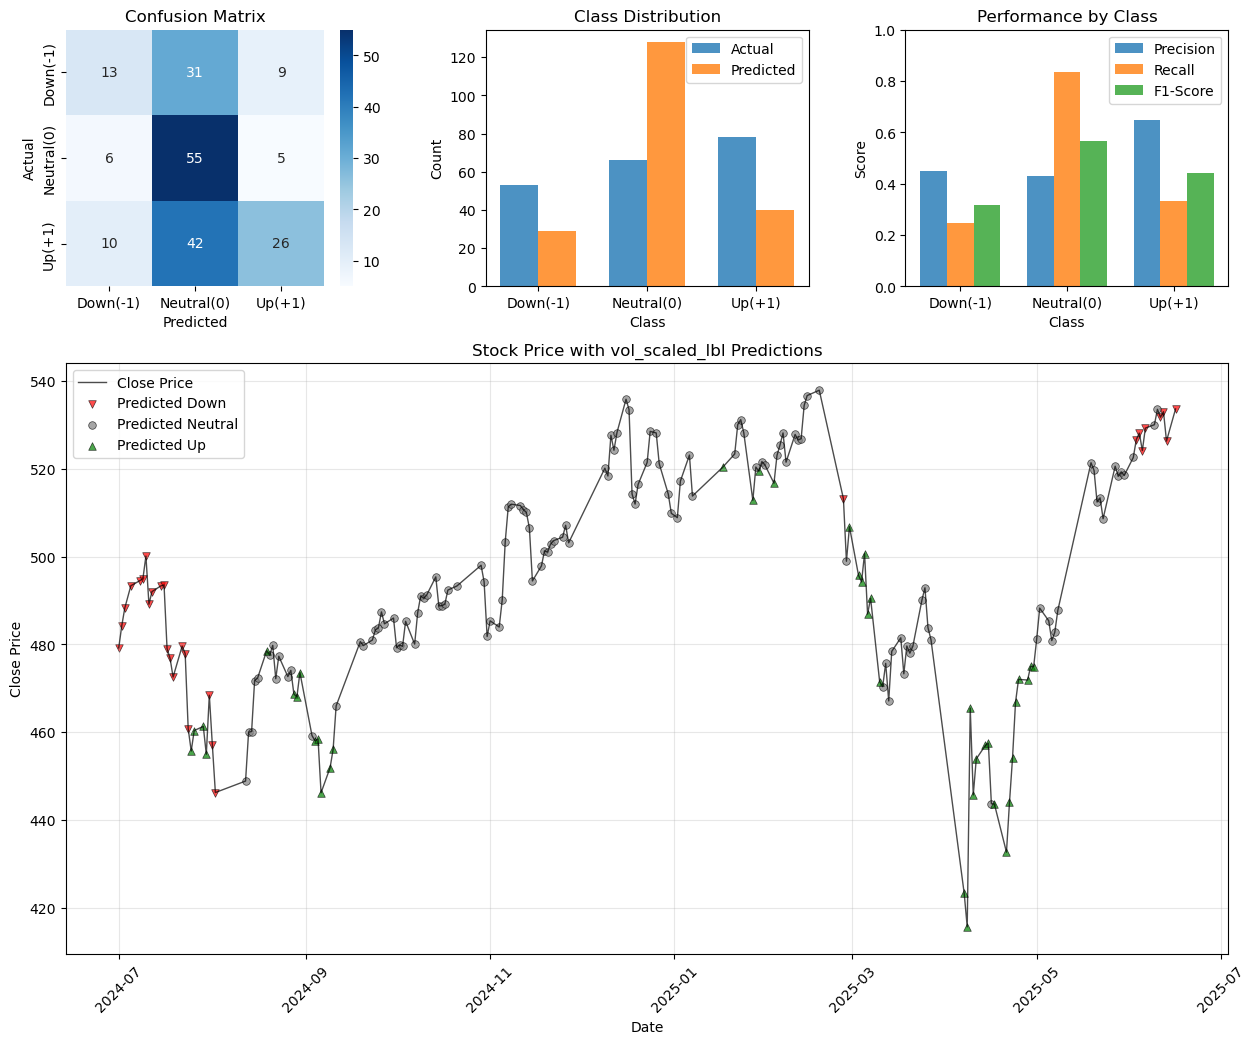

TERNARY CLASSIFIER PERFORMANCE ANALYSIS

Overall Accuracy: 0.4772
Total Predictions: 197

Class Distribution (Actual):
     Down (-1):    53 ( 26.9%)
  Neutral ( 0):    66 ( 33.5%)
       Up ( 1):    78 ( 39.6%)

Class Distribution (Predicted):
     Down (-1):    29 ( 14.7%)
  Neutral ( 0):   128 ( 65.0%)
       Up ( 1):    40 ( 20.3%)

Detailed Classification Report:
              precision    recall  f1-score   support

    Down(-1)     0.4483    0.2453    0.3171        53
  Neutral(0)     0.4297    0.8333    0.5670        66
      Up(+1)     0.6500    0.3333    0.4407        78

    accuracy                         0.4772       197
   macro avg     0.5093    0.4706    0.4416       197
weighted avg     0.5219    0.4772    0.4497       197

Directional Accuracy (Up/Down only): 0.6724

Signal Statistics:
  Up signals: 40 (20.3%)
  Down signals: 29 (14.7%)
  Neutral signals: 128 (65.0%)
  Trading frequency: 35.0%


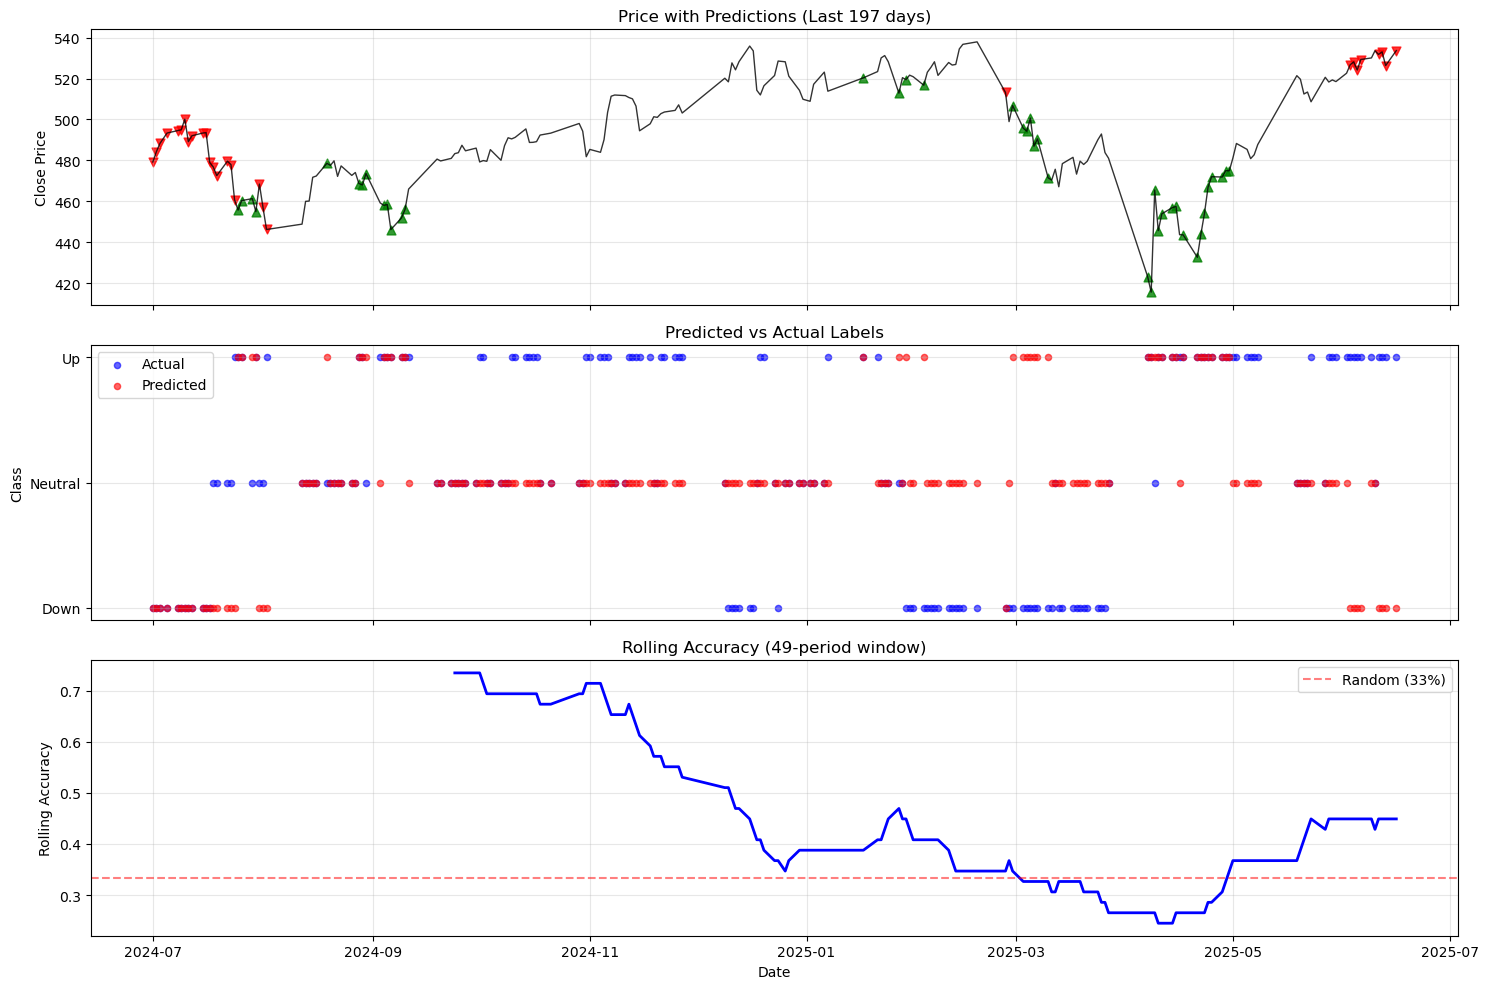

In [22]:
# Example usage function
#def run_analysis_example():

analysis_results = analyze_ternary_classifier(results, ohlcv, target_col='vol_scaled_lbl')
plot_prediction_timeline(results, ohlcv, window_days=252, target_col='vol_scaled_lbl')

And that's that!  Feel free to play around with the dates, tickers, params, etc..  